# GP spectrum model
## We want a mean model and uncertainty band, but for each prepositional phrase


Author: Michael Gully-Santiago  
Date: April 25, 2023

We want an uncertainty band.

In [1]:
import numpy as np
import pandas as pd
import os
import glob
from astropy.io import fits
import warnings
import matplotlib.pyplot as plt
import astropy.units as u
from muler.hpf import HPFSpectrum
import seaborn as sns

from specutils.fitting import fit_continuum
from astropy.modeling import models

from astropy.time import Time
import lightkurve as lk
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context('paper', font_scale=1.2)

#from pandas.core.common import SettingWithCopyWarning

#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", message="Model is linear in parameters")

/Users/mag3842/mambaforge/envs/disperse_env/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/mag3842/.lightkurve/cache. Please move all the files in the legacy directory /Users/mag3842/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

## Featch metadata table

In [3]:
import pyarrow.feather as feather

In [4]:
df = feather.read_feather('../../data/HPF/HAT_P_67_log.feather')

## Assign the orbital phase

Let's compute the normalized phase shifted so that the transit midpoint always occurs at zero while also seeing the light curve before and after the midpoint.

$$\phi=\frac{\mod(t-T_c+\frac{P}{2}\;,P)}{P} -0.5$$ 

In [5]:
target_name = 'HAT-P-67b'
orbital_period = 4.81010250
t_c = 2455961.38467
t_c_btjd = t_c - 2457000.0 #neg value means discovered before TESS
t_14_hours = 6.989 # transit duration in hours
t_14_days = t_14_hours/24.0
t_14_orb_phase = t_14_days / orbital_period

Assign the "campaigns" surrounding individual transits.

In [6]:
from astropy.time import Time
import astropy.units as u

## Post-process the spectra
Apply the same method to each spectrum.  We will define some continuum indices to flatten to.

In [7]:
blue_limits = (10826.5*u.Angstrom, 10827.5*u.Angstrom)
red_limits = (10839.2*u.Angstrom, 10840.2*u.Angstrom)

window = [blue_limits, red_limits]

In [8]:
def flatten_to_regions(spec, windows, polynomial_order=None):
    """Flatten a spectrum to featureless continuum input regions
    
    Parameters:
    ----------
    spec (Spectrum1D-like):
        A spectrum to be flattened
    window (list of tuples):
        A list of pairs of boundaries at which the straight line will be computed
    polynomial_order (int):
        The polynomial order of the fit (defaults to 1-- straight line)
    """
    if polynomial_order is None:
        polynomial_order = 1
    linear_model = models.Chebyshev1D(polynomial_order)
    continuum_func = fit_continuum(spec, window=windows, model=linear_model)
    return spec/continuum_func(spec.wavelength)

In [9]:
fn = df.full_path.values[0]

In [10]:
spec_list = []
for fn in tqdm(df.full_path.values):
    spec_raw = HPFSpectrum(file=fn, order=19)
    spec =  spec_raw.sky_subtract(method='vector')\
                    .remove_nans()\
                    .trim_edges()\
                    .deblaze()\
                    .mask_tellurics(threshold=0.95, dilation=3)\
                    .barycentric_correct().normalize()
    spec = spec.rv_shift(+1.4)
    spec = flatten_to_regions(spec, window)
    spec_list.append(spec)

  0%|          | 0/152 [00:00<?, ?it/s]

In [12]:
len(spec_list)

152

In [13]:
feature_indices = (10832.3, 10834.2)

In [14]:
len(spec_list)

152

In [15]:
out_of_transit_mask = (df.normalized_phase > 0.3) & (df.normalized_phase < 0.46)

In [16]:
out_of_transit_mask.sum()

11

(0.7, 1.1)

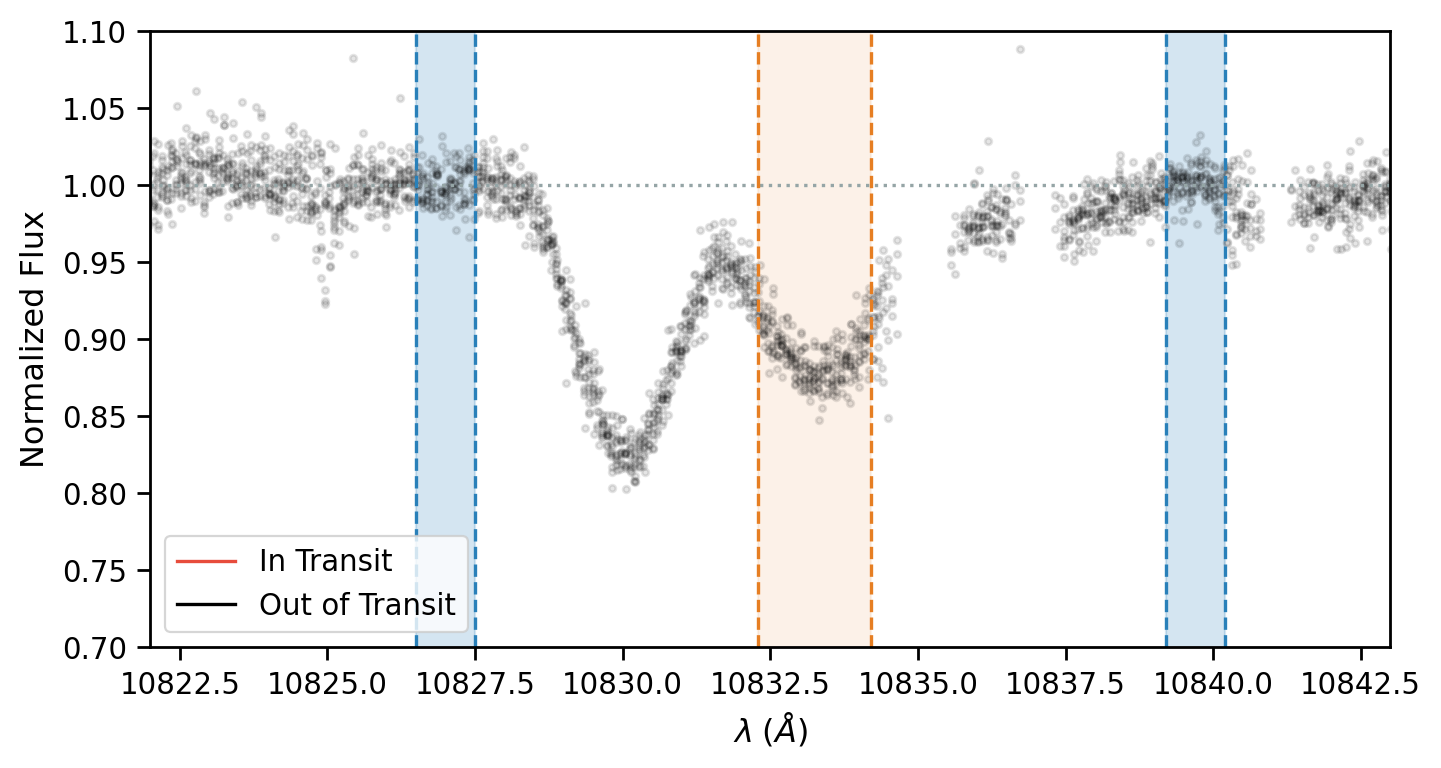

In [17]:
fig, ax = plt.subplots(figsize=(8, 4))

for i, spec in enumerate(spec_list):
    if (df.iloc[i].normalized_phase > 0.3) & (df.iloc[i].normalized_phase < 0.46):
        #spec.plot(ax=ax, ylo=0, color='k', alpha=0.1)
        plt.plot(spec.wavelength, spec.flux, 'k.', alpha=0.1)
    
(spec*0.0).plot(ax=ax, color='#e74c3c', alpha=1, label='In Transit')
(spec*0.0).plot(ax=ax, color='k', alpha=1, label='Out of Transit')
#(spec*0.0).plot(ax=ax, color='#3498db', alpha=1, label='Extended Ingress')


ax.set_xlim(10822, 10843)
ax.axhline(1.0, linestyle='dotted', color='#95a5a6')

ax.axvline(blue_limits[0].value, linestyle='dashed', color='#2980b9')
ax.axvline(blue_limits[1].value, linestyle='dashed', color='#2980b9')
ax.fill_between([x.value for x in blue_limits], [2, 2], alpha=0.2, color='#2980b9')

ax.axvline(feature_indices[0], linestyle='dashed', color='#e67e22')
ax.axvline(feature_indices[1], linestyle='dashed', color='#e67e22')
ax.fill_between(feature_indices, [2, 2], alpha=0.1, color='#e67e22', zorder=0)

ax.axvline(red_limits[0].value, linestyle='dashed', color='#2980b9')
ax.axvline(red_limits[1].value, linestyle='dashed', color='#2980b9')
ax.fill_between([x.value for x in red_limits], [2, 2], alpha=0.2, color='#2980b9')

ax.set_xlabel('$\lambda\;(\AA)$')
ax.set_ylabel('Normalized Flux')

plt.legend()

ax.set_ylim(0.7, 1.1)
#plt.savefig('../../figures/HAT_P_67b_GP_spectrum_band.png', bbox_inches='tight', dpi=300);

## Fit a GP to this signal

Let's try to fit without a mean model

In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
spec.wavelength.value

array([10820.52072078, 10820.5998174 , 10820.67890406, ...,
       10958.03786259, 10958.09430016, 10958.15072564])

In [20]:
t = np.hstack([spec.wavelength.value for spec in np.array(spec_list)[out_of_transit_mask]])
y = np.hstack([spec.flux.value for spec in np.array(spec_list)[out_of_transit_mask]])

m = (t>10825) & (t<10840.3)

t, y = t[m], y[m]

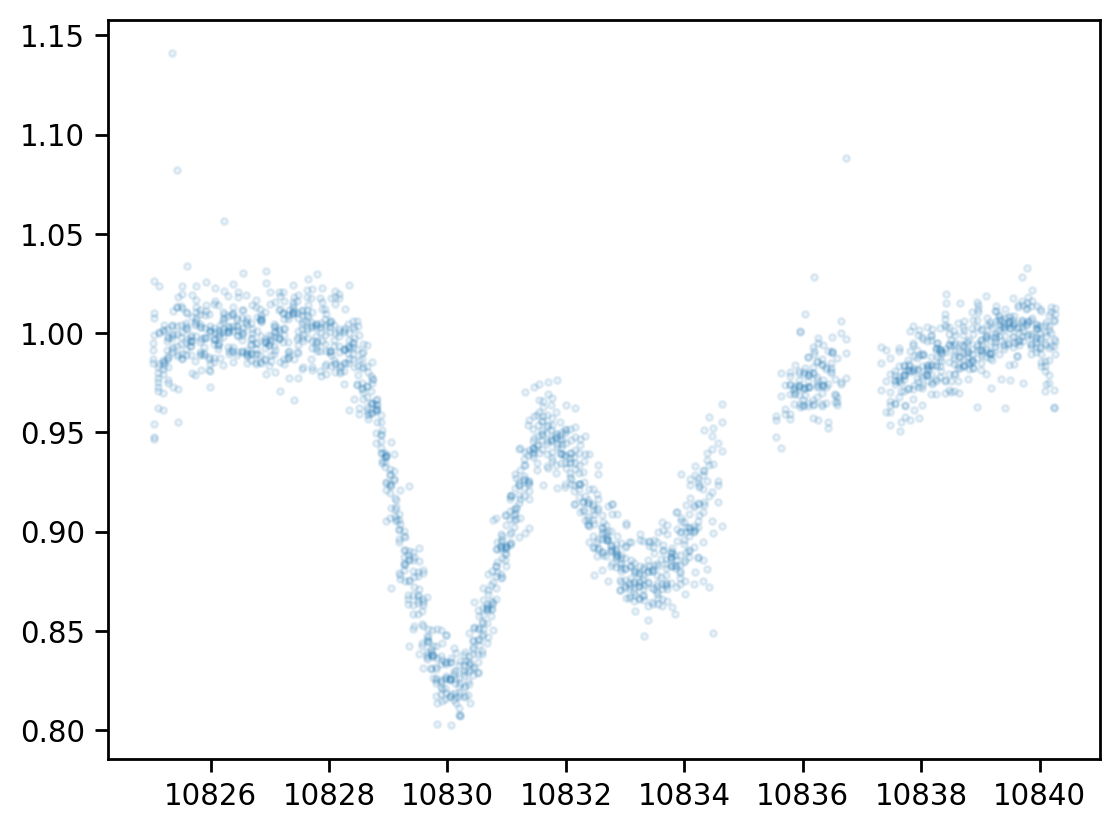

In [21]:
plt.plot(t, y, '.', alpha=0.1)

In [22]:
import jax
import jax.numpy as jnp

from tinygp import kernels, GaussianProcess


jax.config.update("jax_enable_x64", True)

In [23]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    amps = jnp.exp(theta["log_amps"])
    scales = jnp.exp(theta["log_scales"])

    # Construct the kernel by multiplying and adding `Kernel` objects
    k1 = amps[0] * kernels.ExpSquared(scales[0])
    k2 = (
        amps[1]
        * kernels.Matern32(
            scale=jnp.exp(scales[1])
        )
    )
    
    kernel = k1 + k2

    return GaussianProcess(
        kernel, X, diag=jnp.exp(theta["log_diag"]), mean=theta["mean"]
    )

In [24]:
def neg_log_likelihood(theta, X, y):
    gp = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    "mean": np.float64(1.0),
    "log_diag": np.log(0.01),
    "log_amps": np.log([0.1, 0.2]),
    "log_scales": np.log([10.0, 3.1]),
}

# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

Initial negative log likelihood: -2503.8160922509082
Gradient of the negative log likelihood, wrt the parameters:
{'log_amps': Array([  0.71251455, -16.69938554], dtype=float64), 'log_diag': Array(886.63873374, dtype=float64), 'log_scales': Array([ -1.18782736, 160.17770089], dtype=float64), 'mean': Array(0.29580136, dtype=float64)}


In [25]:
import jaxopt

solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
soln = solver.run(theta_init, X=t, y=y)
print(f"Final negative log likelihood: {soln.state.fun_val}")

Final negative log likelihood: -5371.2365771017385


In [26]:
out_of_transit_params = soln.params
out_of_transit_GP = build_gp(out_of_transit_params, t)

## Make a GP model for the out-of-transit

In [27]:
def gp_out_of_transit_interpolator(wl_in, y=y, gp=out_of_transit_GP):
    '''Makes an out-of-transit model for given spectral coordinates'''
    cond_gp = gp.condition(y, wl_in).gp
    mu, var = cond_gp.loc, cond_gp.variance
    return mu, np.sqrt(var)

In [28]:
spec = spec_list[0]

mask = (spec.wavelength.value>10825) & (spec.wavelength.value<10840.3)

In [29]:
t_sample = np.linspace(t.min(), t.max(), num=2000)

In [30]:
out_of_transit_flux, unc  = gp_out_of_transit_interpolator(t_sample)

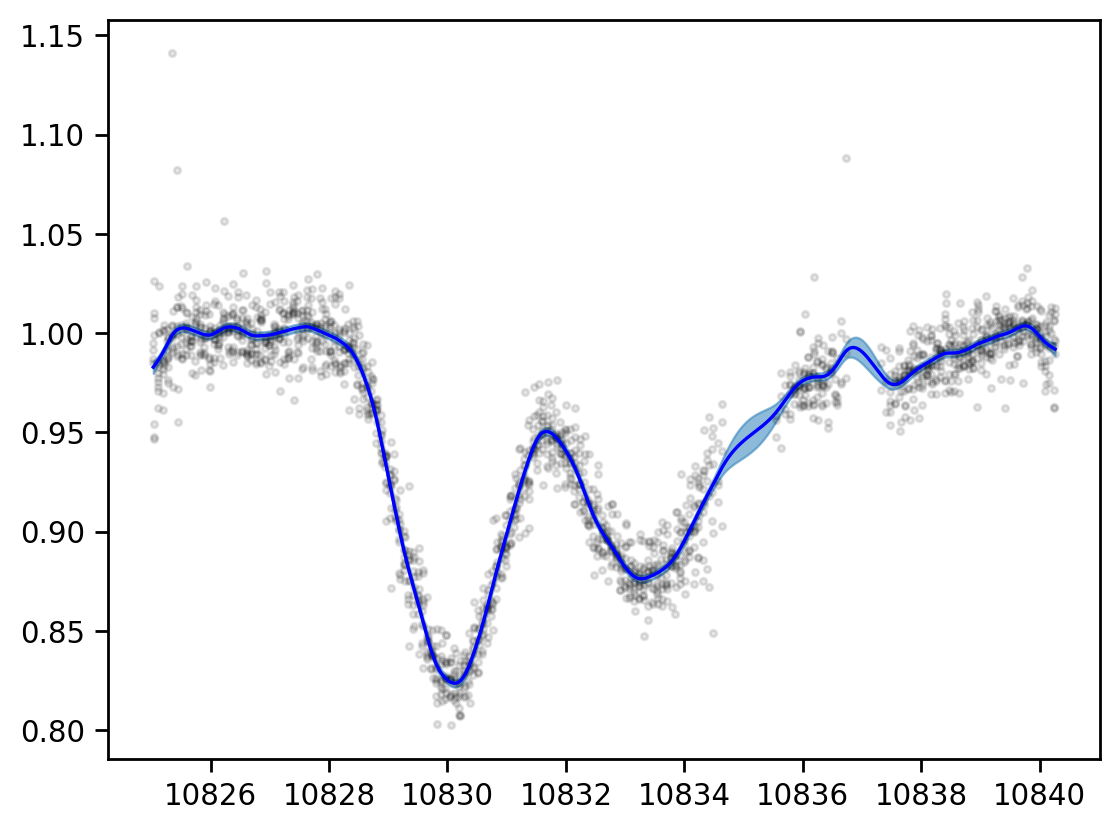

In [31]:
plt.step(t, y, 'k.', alpha=0.1)
plt.plot(t_sample, out_of_transit_flux, 'b-')
plt.fill_between(
    t_sample, out_of_transit_flux + unc, out_of_transit_flux - unc, color="C0", alpha=0.5
)

In [32]:
from scipy.signal import find_peaks

In [33]:
vector = np.array(out_of_transit_flux)

In [34]:
locs, info = find_peaks(-vector)

In [35]:
t_sample[locs]

array([10825.96157678, 10826.79196774, 10830.12876813, 10833.28273015,
       10836.26909031, 10837.54134069, 10838.5164787 ])

(-3.0, 3.0)

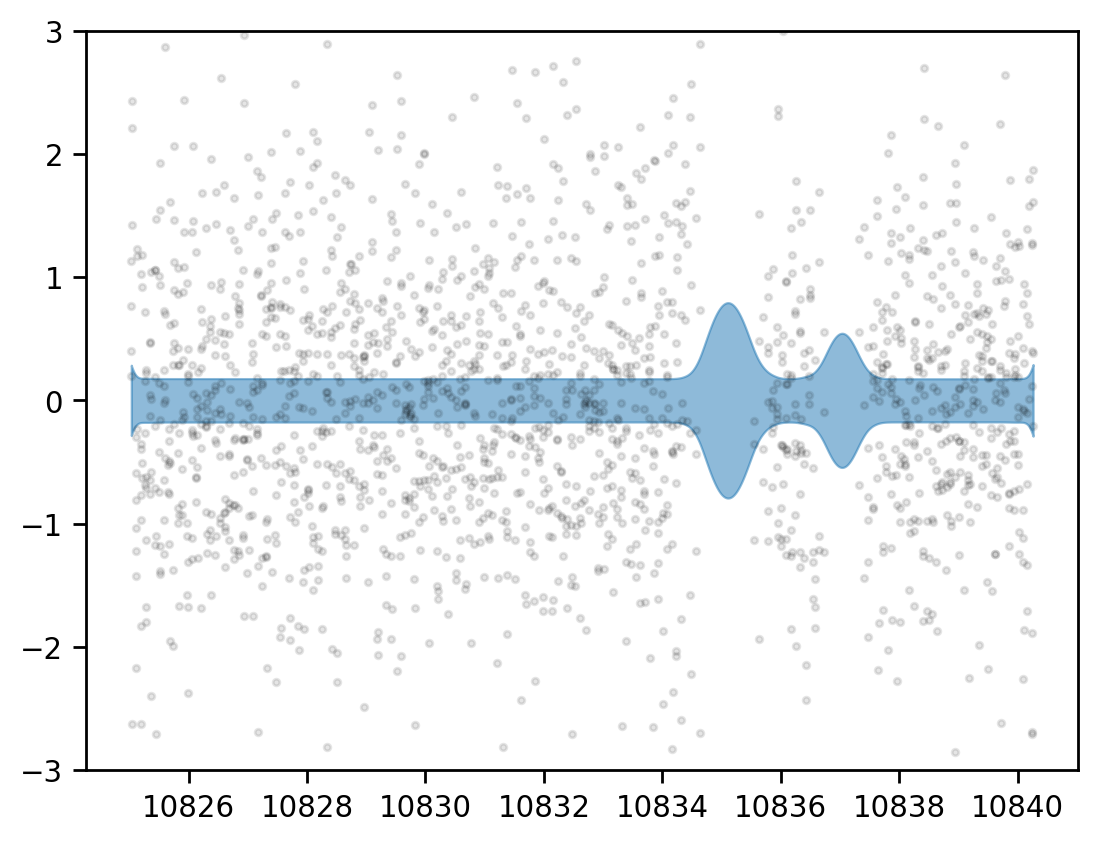

In [36]:
sigma = 0.011
mu, _ = gp_out_of_transit_interpolator(t)
plt.step(t, (y-mu)/sigma, 'k.', alpha=0.1)
plt.fill_between(
    t_sample, unc/sigma, -unc/sigma, color="C0", alpha=0.5
)
plt.ylim(-3, 3)

Checks out!  Let's subtract this signal from all spectra.

In [37]:
from specutils import Spectrum1D

In [38]:
from astropy.nddata import StdDevUncertainty

In [39]:
spec_list_residue = []
for spec in tqdm(spec_list):
    mask = (spec.wavelength.value>10825) & (spec.wavelength.value<10840.3)
    spec_residue = spec.apply_boolean_mask(mask)
    out_of_transit_flux, unc  = gp_out_of_transit_interpolator(spec_residue.wavelength.value)
    out_of_transit_spec = Spectrum1D(flux=out_of_transit_flux*u.dimensionless_unscaled,
                                 spectral_axis=spec_residue.wavelength,
                                 uncertainty=StdDevUncertainty(unc))
    spec_residue = spec_residue.subtract(out_of_transit_spec, handle_meta='ff')
    spec_list_residue.append(spec_residue)

  0%|          | 0/152 [00:00<?, ?it/s]

In [40]:
len(spec_list_residue)

152

In [41]:
spec = spec_list_residue[51]

(-0.2, 0.1)

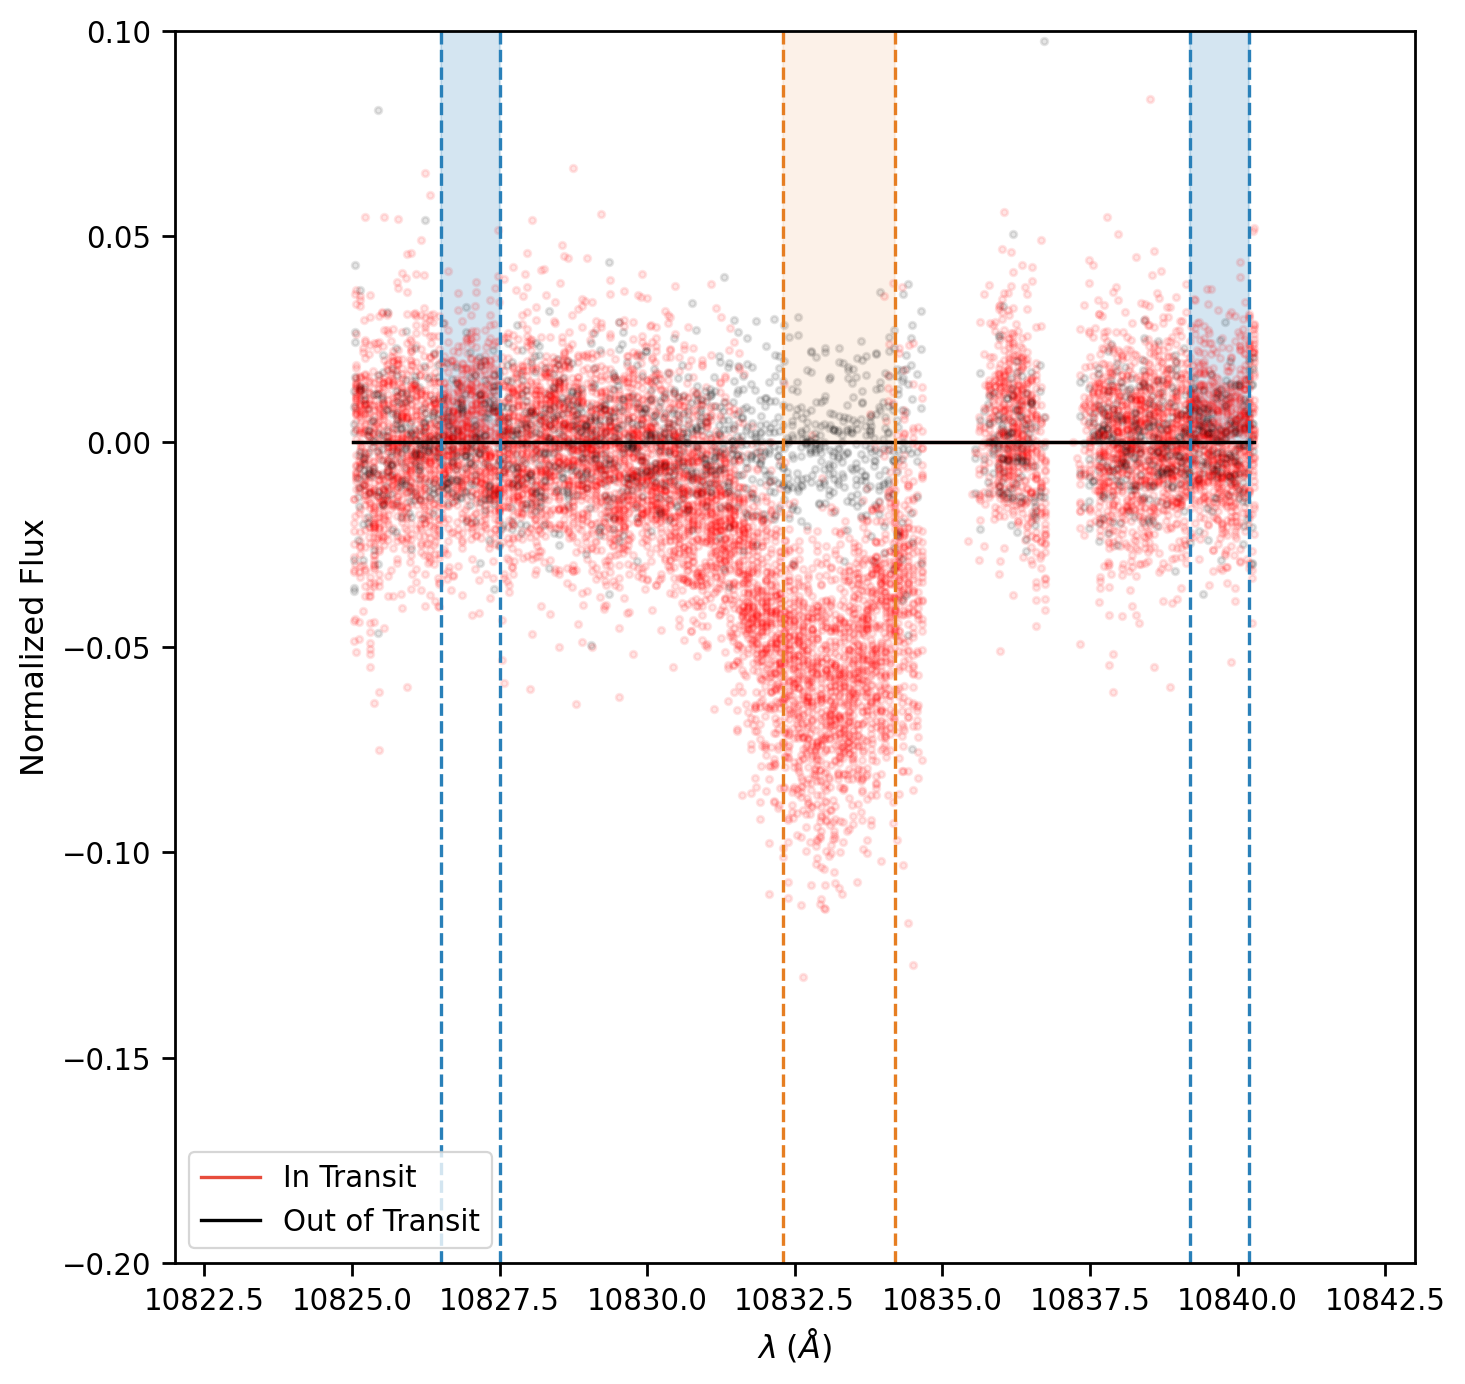

In [42]:
fig, ax = plt.subplots(figsize=(8, 8))

for i, spec in enumerate(spec_list_residue):
    if (df.iloc[i].normalized_phase > 0.3) & (df.iloc[i].normalized_phase < 0.46):
        #spec.plot(ax=ax, ylo=0, color='k', alpha=0.1)
        plt.plot(spec.wavelength, spec.flux, 'k.', alpha=0.1)
    elif (df.iloc[i].normalized_phase > -0.03) & (df.iloc[i].normalized_phase < 0.03):
        #spec.plot(ax=ax, ylo=0, color='k', alpha=0.1)
        plt.plot(spec.wavelength, spec.flux, 'r.', alpha=0.1)
    
(spec*0.0).plot(ax=ax, color='#e74c3c', alpha=1, label='In Transit')
(spec*0.0).plot(ax=ax, color='k', alpha=1, label='Out of Transit')
#(spec*0.0).plot(ax=ax, color='#3498db', alpha=1, label='Extended Ingress')


ax.set_xlim(10822, 10843)
ax.axhline(1.0, linestyle='dotted', color='#95a5a6')

ax.axvline(blue_limits[0].value, linestyle='dashed', color='#2980b9')
ax.axvline(blue_limits[1].value, linestyle='dashed', color='#2980b9')
ax.fill_between([x.value for x in blue_limits], [2, 2], alpha=0.2, color='#2980b9')

ax.axvline(feature_indices[0], linestyle='dashed', color='#e67e22')
ax.axvline(feature_indices[1], linestyle='dashed', color='#e67e22')
ax.fill_between(feature_indices, [2, 2], alpha=0.1, color='#e67e22', zorder=0)

ax.axvline(red_limits[0].value, linestyle='dashed', color='#2980b9')
ax.axvline(red_limits[1].value, linestyle='dashed', color='#2980b9')
ax.fill_between([x.value for x in red_limits], [2, 2], alpha=0.2, color='#2980b9')

ax.set_xlabel('$\lambda\;(\AA)$')
ax.set_ylabel('Normalized Flux')

plt.legend()

ax.set_ylim(-0.2, 0.1)
#plt.savefig('../../figures/HAT_P_67b_GP_spectrum_band.png', bbox_inches='tight', dpi=300);

## Figure requested by CVM on May 22, 2023

It has a panel for each transit

In [43]:
from muler.utilities import combine_spectra_misaligned

In [44]:
pixel_midpoints = spec_raw.wavelength.value

In [45]:
import copy

In [46]:
spec_list_residue_backup = copy.deepcopy(spec_list_residue)

In [47]:
#spec_list_residue = spec_list_residue_backup

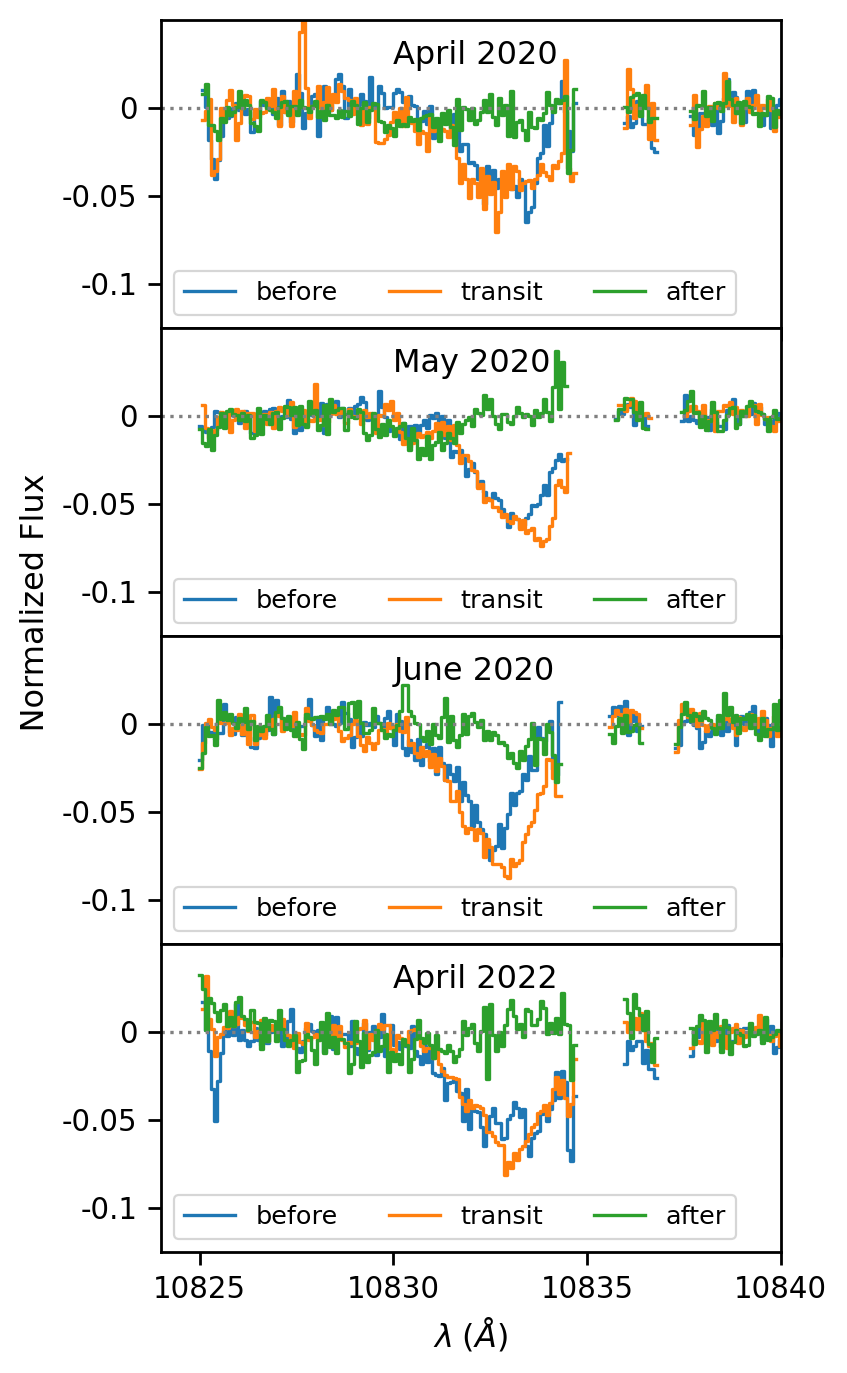

In [48]:
fig, axes = plt.subplots(nrows=4, figsize=(4, 8), sharex=True)

#----------------------------------------------------------------------------------------------
### April 2020
axes[0].text(10830, 0.025, 'April 2020')
night1_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2020-04-26']
night2_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2020-04-27']
night3_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2020-04-28']

night1 = combine_spectra_misaligned(night1_spectra, pixel_midpoints=pixel_midpoints)
night2 = combine_spectra_misaligned(night2_spectra, pixel_midpoints=pixel_midpoints)
night3 = combine_spectra_misaligned(night3_spectra, pixel_midpoints=pixel_midpoints)

axes[0].step(night1.wavelength, night1.flux, label='before', where='mid')
axes[0].step(night2.wavelength, night2.flux, label='transit', where='mid')
axes[0].step(night3.wavelength, night3.flux, label='after', where='mid')
axes[0].legend(fontsize=9.2, ncol=3)
#----------------------------------------------------------------------------------------------

#----------------------------------------------------------------------------------------------
### May 2020
axes[1].text(10830, 0.025, 'May 2020')
night1_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2020-05-20']
night2_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2020-05-21']
night3_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2020-05-22']

night1 = combine_spectra_misaligned(night1_spectra, pixel_midpoints=pixel_midpoints)
night2 = combine_spectra_misaligned(night2_spectra, pixel_midpoints=pixel_midpoints)
night3 = combine_spectra_misaligned(night3_spectra, pixel_midpoints=pixel_midpoints)

axes[1].step(night1.wavelength, night1.flux, label='before', where='mid')
axes[1].step(night2.wavelength, night2.flux, label='transit', where='mid')
axes[1].step(night3.wavelength, night3.flux, label='after', where='mid')
axes[1].legend(fontsize=9.2, ncol=3)
#----------------------------------------------------------------------------------------------

#----------------------------------------------------------------------------------------------
### June 2020
axes[2].text(10830, 0.025, 'June 2020')
night1_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2020-06-13']
night2_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2020-06-14']
night3_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2020-06-15']

night1 = combine_spectra_misaligned(night1_spectra, pixel_midpoints=pixel_midpoints)
night2 = combine_spectra_misaligned(night2_spectra, pixel_midpoints=pixel_midpoints)
night3 = combine_spectra_misaligned(night3_spectra, pixel_midpoints=pixel_midpoints)

axes[2].step(night1.wavelength, night1.flux, label='before', where='mid')
axes[2].step(night2.wavelength, night2.flux, label='transit', where='mid')
axes[2].step(night3.wavelength, night3.flux, label='after', where='mid')
axes[2].legend(fontsize=9.2, ncol=3)
#----------------------------------------------------------------------------------------------

#----------------------------------------------------------------------------------------------
### April 2022
axes[3].text(10830, 0.025, 'April 2022')
night1_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2022-04-27']
night2_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2022-04-28']
night3_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2022-04-29']

night1 = combine_spectra_misaligned(night1_spectra, pixel_midpoints=pixel_midpoints)
night2 = combine_spectra_misaligned(night2_spectra, pixel_midpoints=pixel_midpoints)
night3 = combine_spectra_misaligned(night3_spectra, pixel_midpoints=pixel_midpoints)

axes[3].step(night1.wavelength, night1.flux, label='before', where='mid')
axes[3].step(night2.wavelength, night2.flux, label='transit', where='mid')
axes[3].step(night3.wavelength, night3.flux, label='after', where='mid')

#----------------------------------------------------------------------------------------------

yticks = [-0.1, -0.05, 0]
for ax in axes:
    ax.axhline(0, color='gray', linestyle='dotted')
    ax.set_xlim(10824, 10840)
    ax.set_ylim(-0.125, 0.05)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)
    ax.legend(fontsize=9.2, ncol=3)

axes[3].set_xlabel('$\lambda\;(\AA)$')
xticks = np.arange(10825, 10841, 5, dtype=int)
axes[3].set_xticks(xticks)
axes[3].set_xticklabels(xticks)
axes[2].set_ylabel('                                     Normalized Flux')

plt.subplots_adjust(wspace=0, hspace=0)


#plt.savefig('../../figures/HAT_P_67b_GP_spectrum_band.png', bbox_inches='tight', dpi=300);

In [50]:
spec_list_residue = spec_list

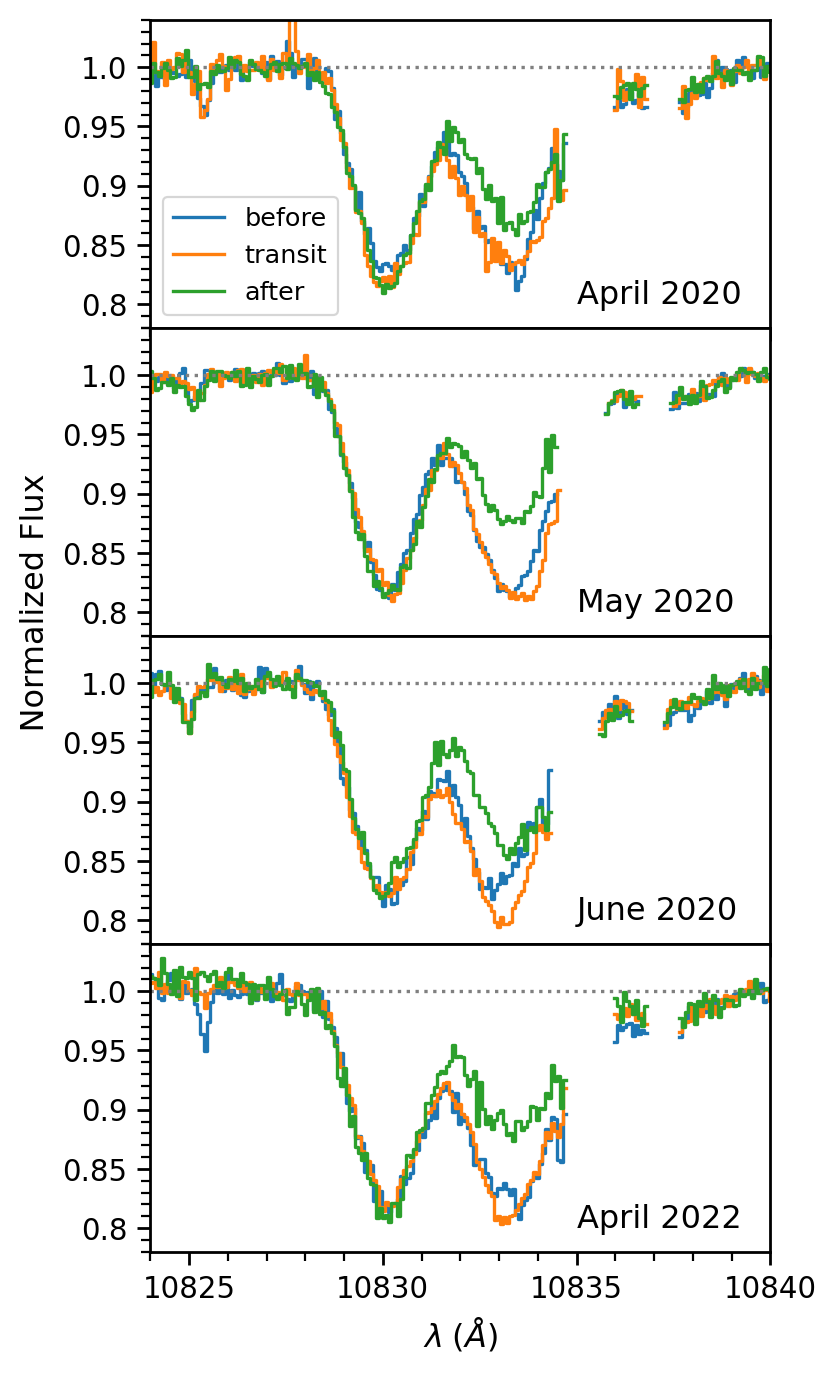

In [55]:
fig, axes = plt.subplots(nrows=4, figsize=(4, 8), sharex=True)

date_ypos = 0.80
date_xpos = 10835
#----------------------------------------------------------------------------------------------
### April 2020
axes[0].text(date_xpos, date_ypos, 'April 2020')
night1_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2020-04-26']
night2_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2020-04-27']
night3_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2020-04-28']

night1 = combine_spectra_misaligned(night1_spectra, pixel_midpoints=pixel_midpoints)
night2 = combine_spectra_misaligned(night2_spectra, pixel_midpoints=pixel_midpoints)
night3 = combine_spectra_misaligned(night3_spectra, pixel_midpoints=pixel_midpoints)

axes[0].step(night1.wavelength, night1.flux, label='before', where='mid')
axes[0].step(night2.wavelength, night2.flux, label='transit', where='mid')
axes[0].step(night3.wavelength, night3.flux, label='after', where='mid')
#----------------------------------------------------------------------------------------------

#----------------------------------------------------------------------------------------------
### May 2020
axes[1].text(date_xpos, date_ypos, 'May 2020')
night1_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2020-05-20']
night2_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2020-05-21']
night3_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2020-05-22']

night1 = combine_spectra_misaligned(night1_spectra, pixel_midpoints=pixel_midpoints)
night2 = combine_spectra_misaligned(night2_spectra, pixel_midpoints=pixel_midpoints)
night3 = combine_spectra_misaligned(night3_spectra, pixel_midpoints=pixel_midpoints)

axes[1].step(night1.wavelength, night1.flux, label='before', where='mid')
axes[1].step(night2.wavelength, night2.flux, label='transit', where='mid')
axes[1].step(night3.wavelength, night3.flux, label='after', where='mid')
#----------------------------------------------------------------------------------------------

#----------------------------------------------------------------------------------------------
### June 2020
axes[2].text(date_xpos, date_ypos, 'June 2020')
night1_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2020-06-13']
night2_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2020-06-14']
night3_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2020-06-15']

night1 = combine_spectra_misaligned(night1_spectra, pixel_midpoints=pixel_midpoints)
night2 = combine_spectra_misaligned(night2_spectra, pixel_midpoints=pixel_midpoints)
night3 = combine_spectra_misaligned(night3_spectra, pixel_midpoints=pixel_midpoints)

axes[2].step(night1.wavelength, night1.flux, label='before', where='mid')
axes[2].step(night2.wavelength, night2.flux, label='transit', where='mid')
axes[2].step(night3.wavelength, night3.flux, label='after', where='mid')
#----------------------------------------------------------------------------------------------

#----------------------------------------------------------------------------------------------
### April 2022
axes[3].text(date_xpos, date_ypos, 'April 2022')
night1_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2022-04-27']
night2_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2022-04-28']
night3_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2022-04-29']

night1 = combine_spectra_misaligned(night1_spectra, pixel_midpoints=pixel_midpoints)
night2 = combine_spectra_misaligned(night2_spectra, pixel_midpoints=pixel_midpoints)
night3 = combine_spectra_misaligned(night3_spectra, pixel_midpoints=pixel_midpoints)

axes[3].step(night1.wavelength, night1.flux, label='before', where='mid')
axes[3].step(night2.wavelength, night2.flux, label='transit', where='mid')
axes[3].step(night3.wavelength, night3.flux, label='after', where='mid')
#----------------------------------------------------------------------------------------------

yticks = [0.80, 0.85, 0.90, 0.95, 1.0]
for i, ax in enumerate(axes):
    ax.axhline(1, color='gray', linestyle='dotted')
    ax.set_xlim(10824, 10840)
    ax.set_ylim(0.78, 1.04)
    ax.set_yticks(yticks)
    ax.set_yticks(np.arange(0.78, 1.05, 0.01), minor=True)
    ax.set_yticklabels(yticks)

axes[0].legend(fontsize=9.2, ncol=1, loc='lower left')
axes[3].set_xlabel('$\lambda\;(\AA)$')
xticks = np.arange(10825, 10841, 5, dtype=int)
axes[3].set_xticks(xticks)
axes[3].set_xticks(np.arange(10824, 10841, 1), minor=True)
axes[3].set_xticklabels(xticks)
axes[2].set_ylabel('                                     Normalized Flux')

plt.subplots_adjust(wspace=0, hspace=0)


plt.savefig('../../paper/paper1/figures/HAT_P_67b_byCampaign_Spectra.png', bbox_inches='tight', dpi=300);

In [157]:
[df.iloc[i].normalized_phase for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2020-05-21']

[-0.01123473638882871,
 -0.010413862735911461,
 -0.009593012994821033,
 -0.008772218144442373,
 -0.00795140838547533,
 -0.0071305841051559704,
 -0.006309721198039439,
 -0.005488908631610949,
 -0.004668093644957072,
 -0.0038472441942936906,
 -0.0030264123628711234,
 -0.0022055736580084582,
 -0.0013847457957555248,
 -0.0005638774673341274]

In [111]:
len(night2_spectra)

14

In [138]:
df_save = pd.read_csv('../../data/HPF/GP_mean_InTransit55spec.csv')

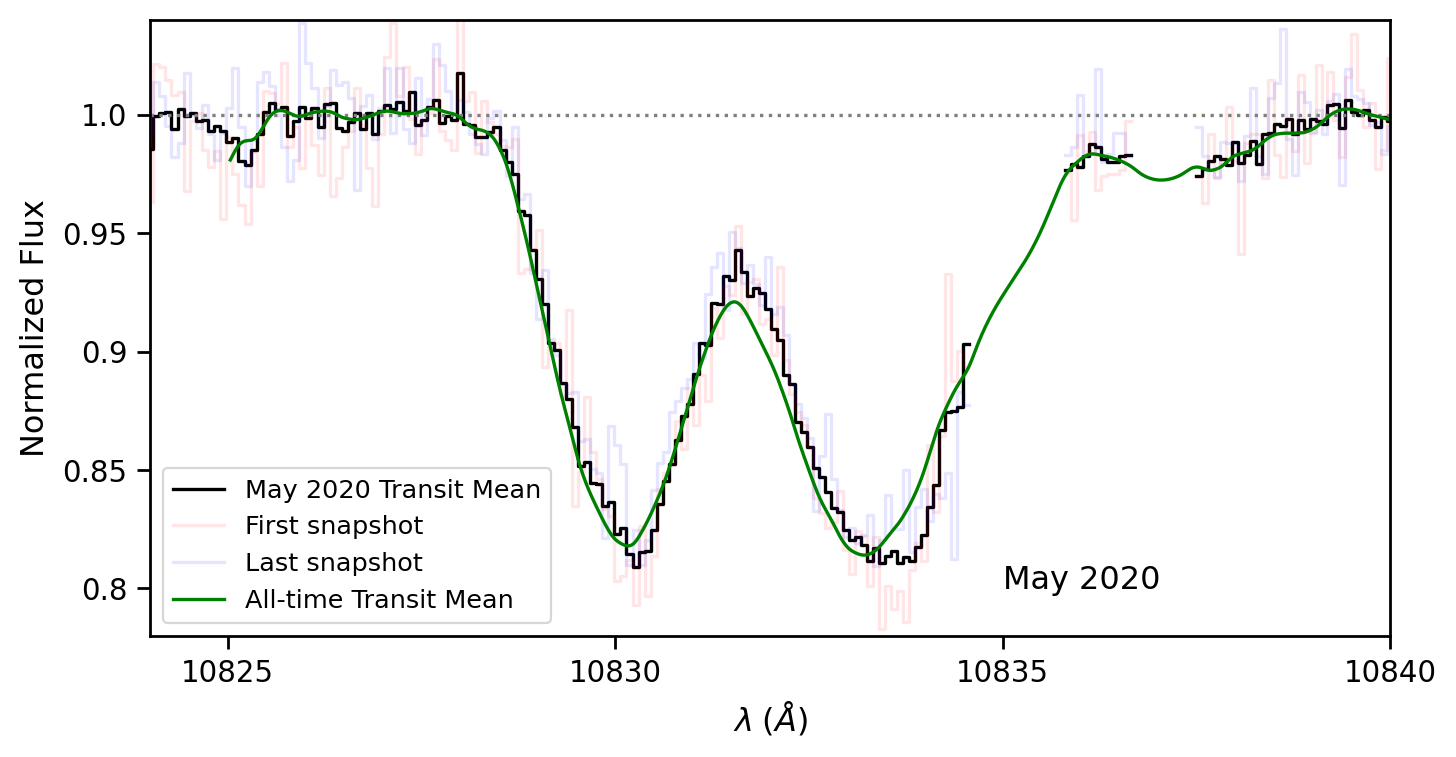

In [169]:
fig, ax = plt.subplots(nrows=1, figsize=(8, 4))

date_ypos = 0.80
date_xpos = 10835

#----------------------------------------------------------------------------------------------
### May 2020
ax.text(date_xpos, date_ypos, 'May 2020')
night0_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2020-05-19']
night1_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2020-05-20']
night2_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2020-05-21']
night3_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2020-05-22']
night4_spectra = [spec for i, spec in enumerate(spec_list_residue) if df.iloc[i].night_of == '2020-05-23']

night4 = combine_spectra_misaligned(night4_spectra, pixel_midpoints=pixel_midpoints)
night0 = combine_spectra_misaligned(night0_spectra, pixel_midpoints=pixel_midpoints)#/night4
night1 = combine_spectra_misaligned(night1_spectra, pixel_midpoints=pixel_midpoints)#/night4
night2 = combine_spectra_misaligned(night2_spectra, pixel_midpoints=pixel_midpoints)#/night4
night3 = combine_spectra_misaligned(night3_spectra, pixel_midpoints=pixel_midpoints)#/night4


#ax.step(night0.wavelength, night0.flux, label='2 days before', where='mid')
#ax.step(night1.wavelength, night1.flux, label='1 day before', where='mid')
ax.step(night2.wavelength, night2.flux, label='May 2020 Transit Mean', where='mid', color='k')
#ax.step(night3.wavelength, night3.flux, label='1 day after', where='mid')
#ax.step(night4.wavelength, night4.flux, label='2 days after', where='mid')

for i, spec in enumerate(night2_spectra):
    spec_resampled = combine_spectra_misaligned([spec], pixel_midpoints=pixel_midpoints)
    spec_rel = spec_resampled#/night4
    if i==13:
        ax.step(spec_rel.wavelength, spec_rel.flux, where='mid', color='b', alpha=0.1,
                label='Last snapshot')
    if i==0:
        spec_keep = spec_rel
        ax.step(spec_rel.wavelength, spec_rel.flux, where='mid',  
                color='r', alpha=0.1, label='First snapshot')

#----------------------------------------------------------------------------------------------

yticks = [0.80, 0.85, 0.90, 0.95, 1.0]

ax.axhline(1, color='gray', linestyle='dotted')
ax.set_xlim(10824, 10840)
ax.set_ylim(0.78, 1.04)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)


ax.set_xlabel('$\lambda\;(\AA)$')
xticks = np.arange(10825, 10841, 5, dtype=int)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.set_ylabel('Normalized Flux')

plt.subplots_adjust(wspace=0, hspace=0)

ax.plot(df_save.wl, df_save.flux, label='All-time Transit Mean', color='g')

ax.legend(fontsize=9.2, ncol=1, loc='lower left')


plt.savefig('../../paper/paper1/figures/HAT_P_67b_May2020.png', bbox_inches='tight', dpi=300);

Let's save the in-transit spectrum to share with Morgan.

In [161]:
mask = (night2.wavelength.value >10824) &  (night2.wavelength.value <10840)

In [165]:
night2_out = night2.apply_boolean_mask(mask)
night2_out_rel = (night2/night4).apply_boolean_mask(mask)

In [170]:
mask = (spec_keep.wavelength.value >10824) &  (spec_keep.wavelength.value <10840)

In [171]:
first_out = spec_keep.apply_boolean_mask(mask)
first_out_rel = (spec_keep/night4).apply_boolean_mask(mask)

In [166]:
df_May2020Mean = pd.DataFrame({'wl':night2_out.wavelength.value, 
                               'flux_abs':night2_out.flux.value,
                            'flux_rel':night2_out_rel.flux.value})

In [172]:
df_May2020First = pd.DataFrame({'wl':first_out.wavelength.value, 
                               'flux_abs':first_out.flux.value,
                            'flux_rel':first_out_rel.flux.value})

In [176]:
df_May2020Mean.to_csv('../../data/HPF/May2020_inTransitMean.csv', index=False)
df_May2020First.to_csv('../../data/HPF/May2020_inTransitSnapshot_phi-0p011.csv', index=False)

In [167]:
df_May2020Mean

,wl,flux_abs,flux_rel
0,10824.076056,0.999463,1.005762
1,10824.154745,1.000779,1.004654
2,10824.233423,1.001156,1.005607
3,10824.312092,0.993872,0.990571
4,10824.390751,1.002303,1.001363
...,...,...,...
201,10839.687493,1.001948,0.996791
202,10839.764118,0.997831,0.993029
203,10839.840732,0.994729,0.997137
204,10839.917336,0.999044,0.998630


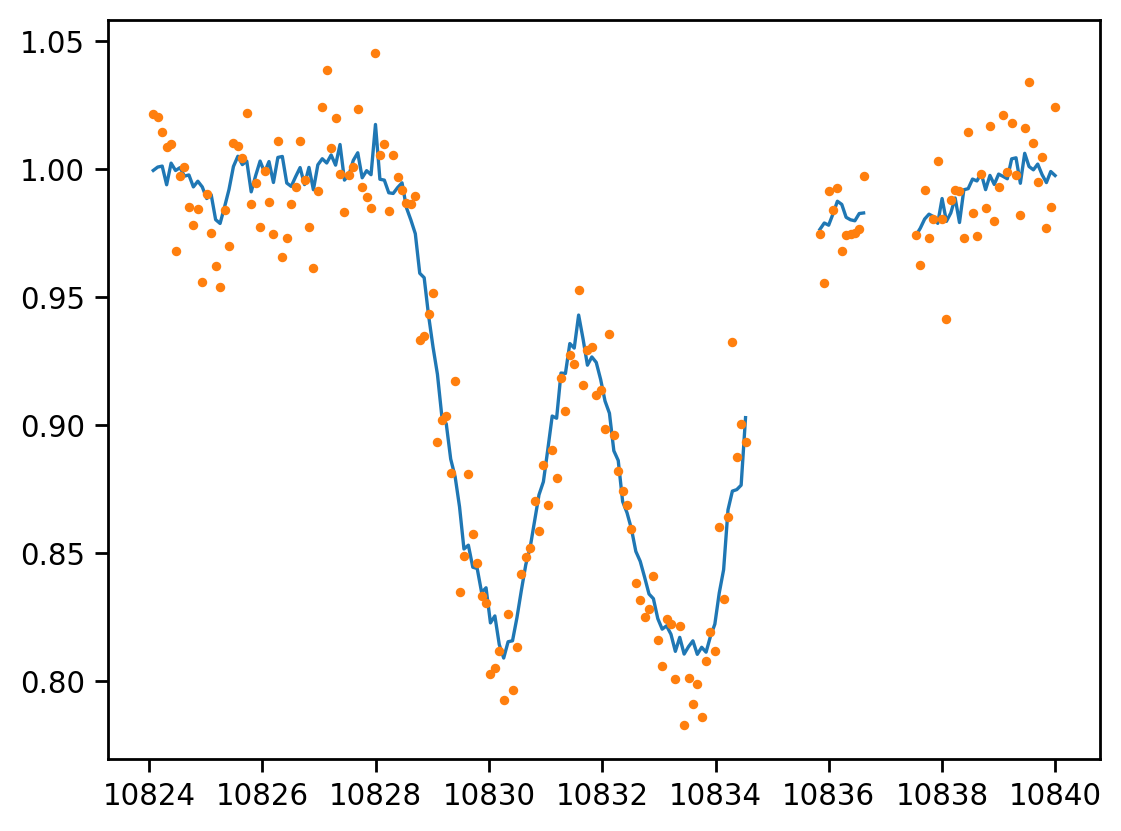

In [175]:
plt.plot(df_May2020Mean.wl, df_May2020Mean.flux_abs)
plt.plot(df_May2020First.wl, df_May2020First.flux_abs, '.')

## Repeat the GP fit for the other prepositions

In [50]:
in_transit_mask = df.preposition == 'Transit'

In [51]:
len(spec_list_residue)

152

In [52]:
tn = np.hstack([spec.wavelength.value for spec in np.array(spec_list_residue)[in_transit_mask]])
yn = np.hstack([spec.flux.value for spec in np.array(spec_list_residue)[in_transit_mask]])

mn = (tn>10825) & (tn<10840.3)

tn, yn = tn[mn], yn[mn]

This takes a long time because there are way more data points than the out-of-transit case.

In [53]:
#soln = solver.run(theta_init, X=tn, y=yn)
#in_transit_params = soln.params

Instead we can just re-use the kernel, which should have approximately the right length scale and amplitude!

In [54]:
in_transit_GP = build_gp(out_of_transit_params, tn)

In [55]:
in_transit_flux, unc_in  = gp_out_of_transit_interpolator(t_sample, y=yn, gp=in_transit_GP)

In [56]:
in_transit_mask.sum()

55

In [57]:
subset = np.array(spec_list_residue)[in_transit_mask]

In [58]:
temp_list = subset.tolist()

In [59]:
i=25

In [60]:
np.std(yn[tn<10828])

0.018400181807279415

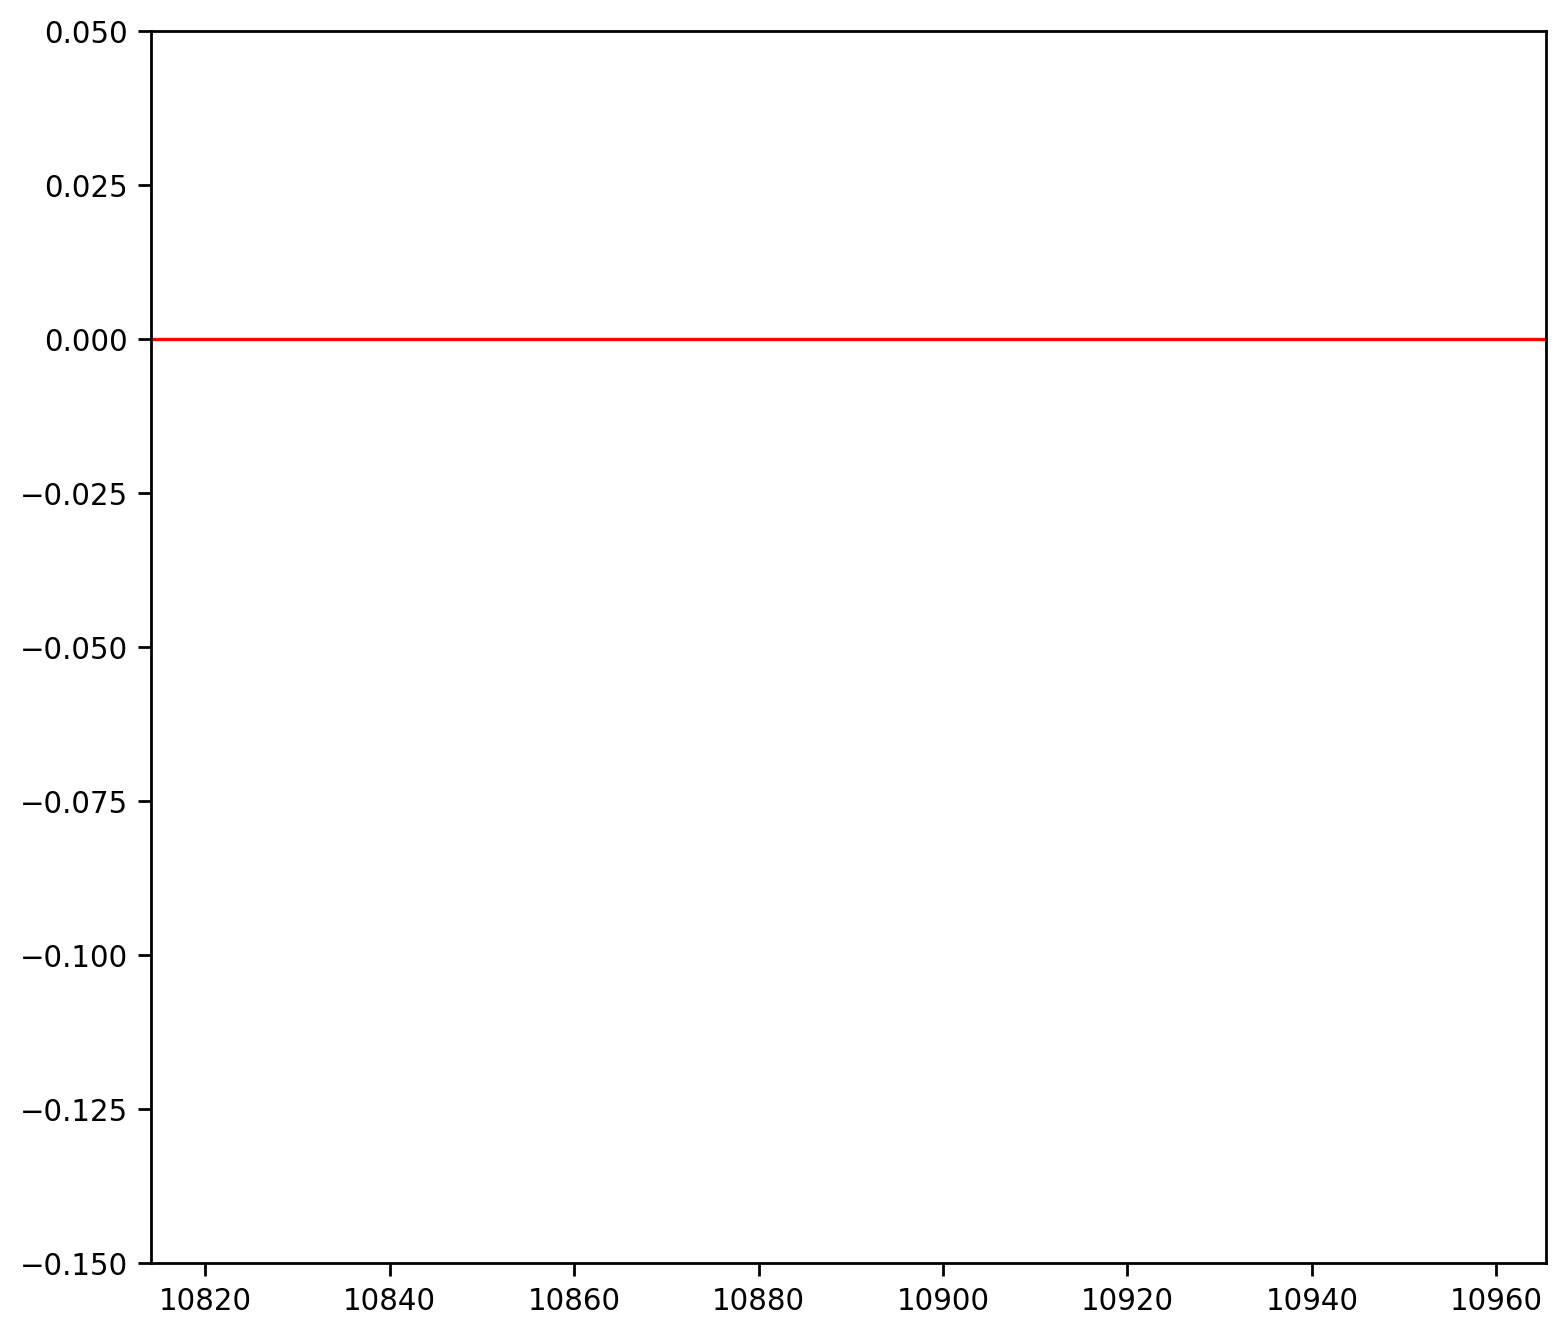

In [61]:
plt.figure(figsize=(9, 8))
plt.step(tn, yn, 'ko', alpha=0.1)
plt.plot(t_sample, in_transit_flux, 'b-')
plt.fill_between(
    t_sample, in_transit_flux + unc_in, in_transit_flux - unc_in, color="C0", alpha=0.5
)
plt.ylim(-0.15, 0.05)

plt.scatter(temp_list[i].wavelength, temp_list[i].flux, color='g', marker='o', s=140, ec='w')
plt.axhline(0.0, color='r')
i+=1

Nice! Running all that code takes a lot of space, so let's just save the mean trend and uncertainty for plotting purposes elsewhere.

In [62]:
df_save = pd.DataFrame({'wl':t_sample, 'flux':in_transit_flux, 'unc':unc_in})

In [63]:
df_save.to_csv('../../data/HPF/GP_mean_InTransit55spec.csv', index=False)

## Get line center positions and widths

fit a model to these spectra:

In [64]:
spec = spec_list_residue[1]

In [65]:
x = spec.wavelength.value
y = spec.flux.value
unc = spec.uncertainty.array

## MCMC Sample

Let's just use a simple Voigt profile with emcee

In [66]:
from scipy.special import voigt_profile
wl_vacuum = [10833.470120589382, 10833.380094831637, 10832.219762843133]

In [67]:
def line_model(theta, wavelength=None):
    baseline, lam_0, ln_amp, ln_sigma = theta
    amp, sigma = np.exp(ln_amp), np.exp(ln_sigma)
    '''fit a Voigt profile with a GP'''
    wl_vector = wavelength - lam_0
    return baseline - amp * np.exp(-0.5*wl_vector**2/sigma**2)

In [68]:
np.exp(-10)

4.5399929762484854e-05

In [69]:
np.exp(1.5)

4.4816890703380645

In [70]:
def lnprior(theta):
    baseline, lam_0, ln_amp, ln_sigma = theta
    if (lam_0 < 10827) | (lam_0 > 10838) | \
        (ln_sigma < -4) | (ln_sigma > 1.5):
        return -np.inf
    else:
        return -(lam_0-10833.0)**2/(15.0**2) - (ln_sigma-0)**2/(5.0**2)

In [71]:
theta_init = [0.0, 10833.0, np.log(0.05), np.log(1)]

In [72]:
lnprior(theta_init)

-0.0

In [73]:
def lnlike(theta, x, y, yerr):
    model = line_model(theta, wavelength=x) 
    return -0.5 * np.sum((y - model) ** 2 / yerr**2)

In [74]:
def lnprob(theta, x, y, yerr):
    prior_value = lnprior(theta)
    likelihood = lnlike(theta, x, y, yerr)
    if likelihood != likelihood:
        return -np.inf
    return prior_value + likelihood

In [75]:
from scipy.optimize import minimize

In [76]:
nll = lambda *args: -lnprob(*args)
soln = minimize(nll, theta_init, args=(x, y, unc))
theta_opt = soln.x

In [77]:
theta_opt

array([ 9.35221446e-01,  1.08323364e+04, -2.61551619e+00,  6.05926143e-01])

(10824.0, 10841.0)

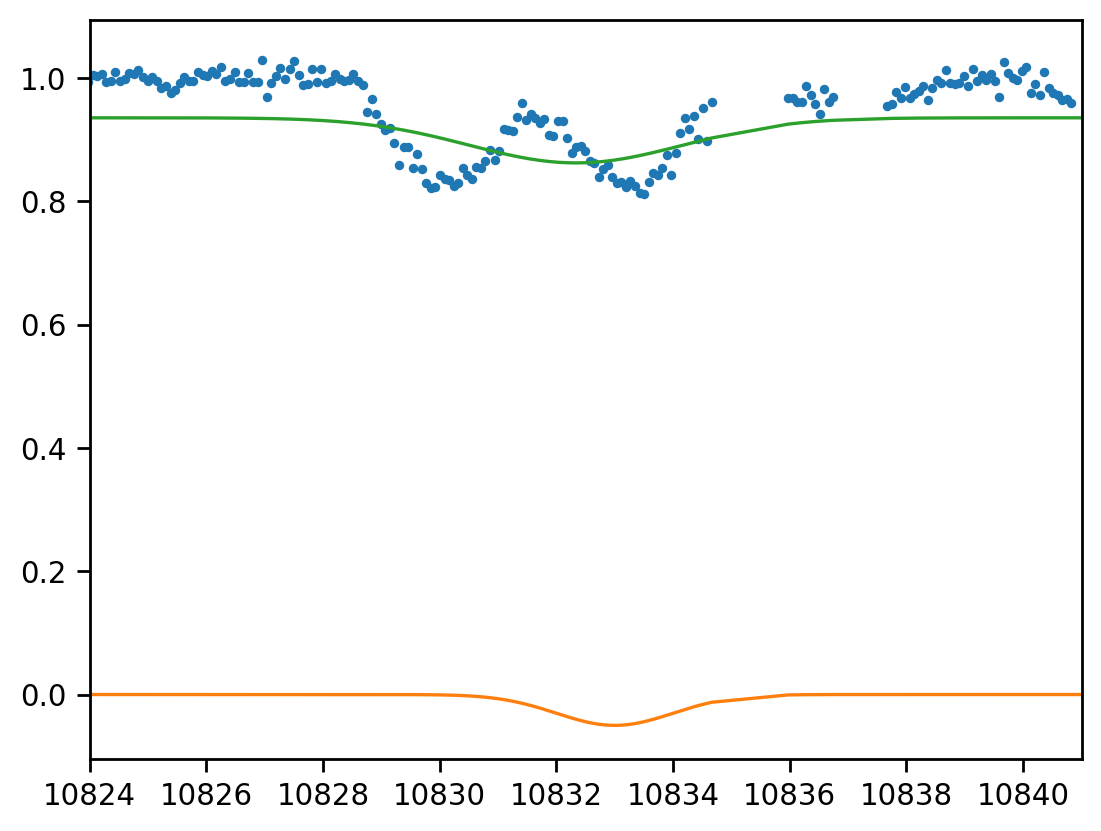

In [78]:
flux = line_model([0.0, 10833.0, np.log(0.05), np.log(1)],\
                   wavelength=spec.wavelength.value) 

flux_opt = line_model(theta_opt,\
                   wavelength=spec.wavelength.value) 

plt.plot(spec.wavelength.value, spec.flux.value, '.')
plt.plot(spec.wavelength.value, flux)
plt.plot(spec.wavelength.value, flux_opt)
plt.xlim(10824, 10841)

In [79]:
ndim = len(theta_init)
nwalkers = 40
scales = [0.001, 0.1, 0.01, 0.01]
perturbations = np.vstack([np.random.normal(scale=scale, size=nwalkers) for scale in scales])

In [80]:
p0 = theta_init + perturbations.T

In [81]:
import emcee

In [82]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, lnprob, args=(x, y, unc)
)
sampler.run_mcmc(p0, 5000, progress=True);

100%|█████████████████████████████████████| 5000/5000 [00:04<00:00, 1127.66it/s]


In [83]:
labels = ['baseline', 'lam_0', 'amp', 'sigma']

In [84]:
def transform_samples(samples):
    '''Convert samples to back to physical units'''    
    samples_absolute = np.copy(samples)
    samples_absolute[:,:, 2:] = np.exp(samples[:,:, 2:])
    return samples_absolute

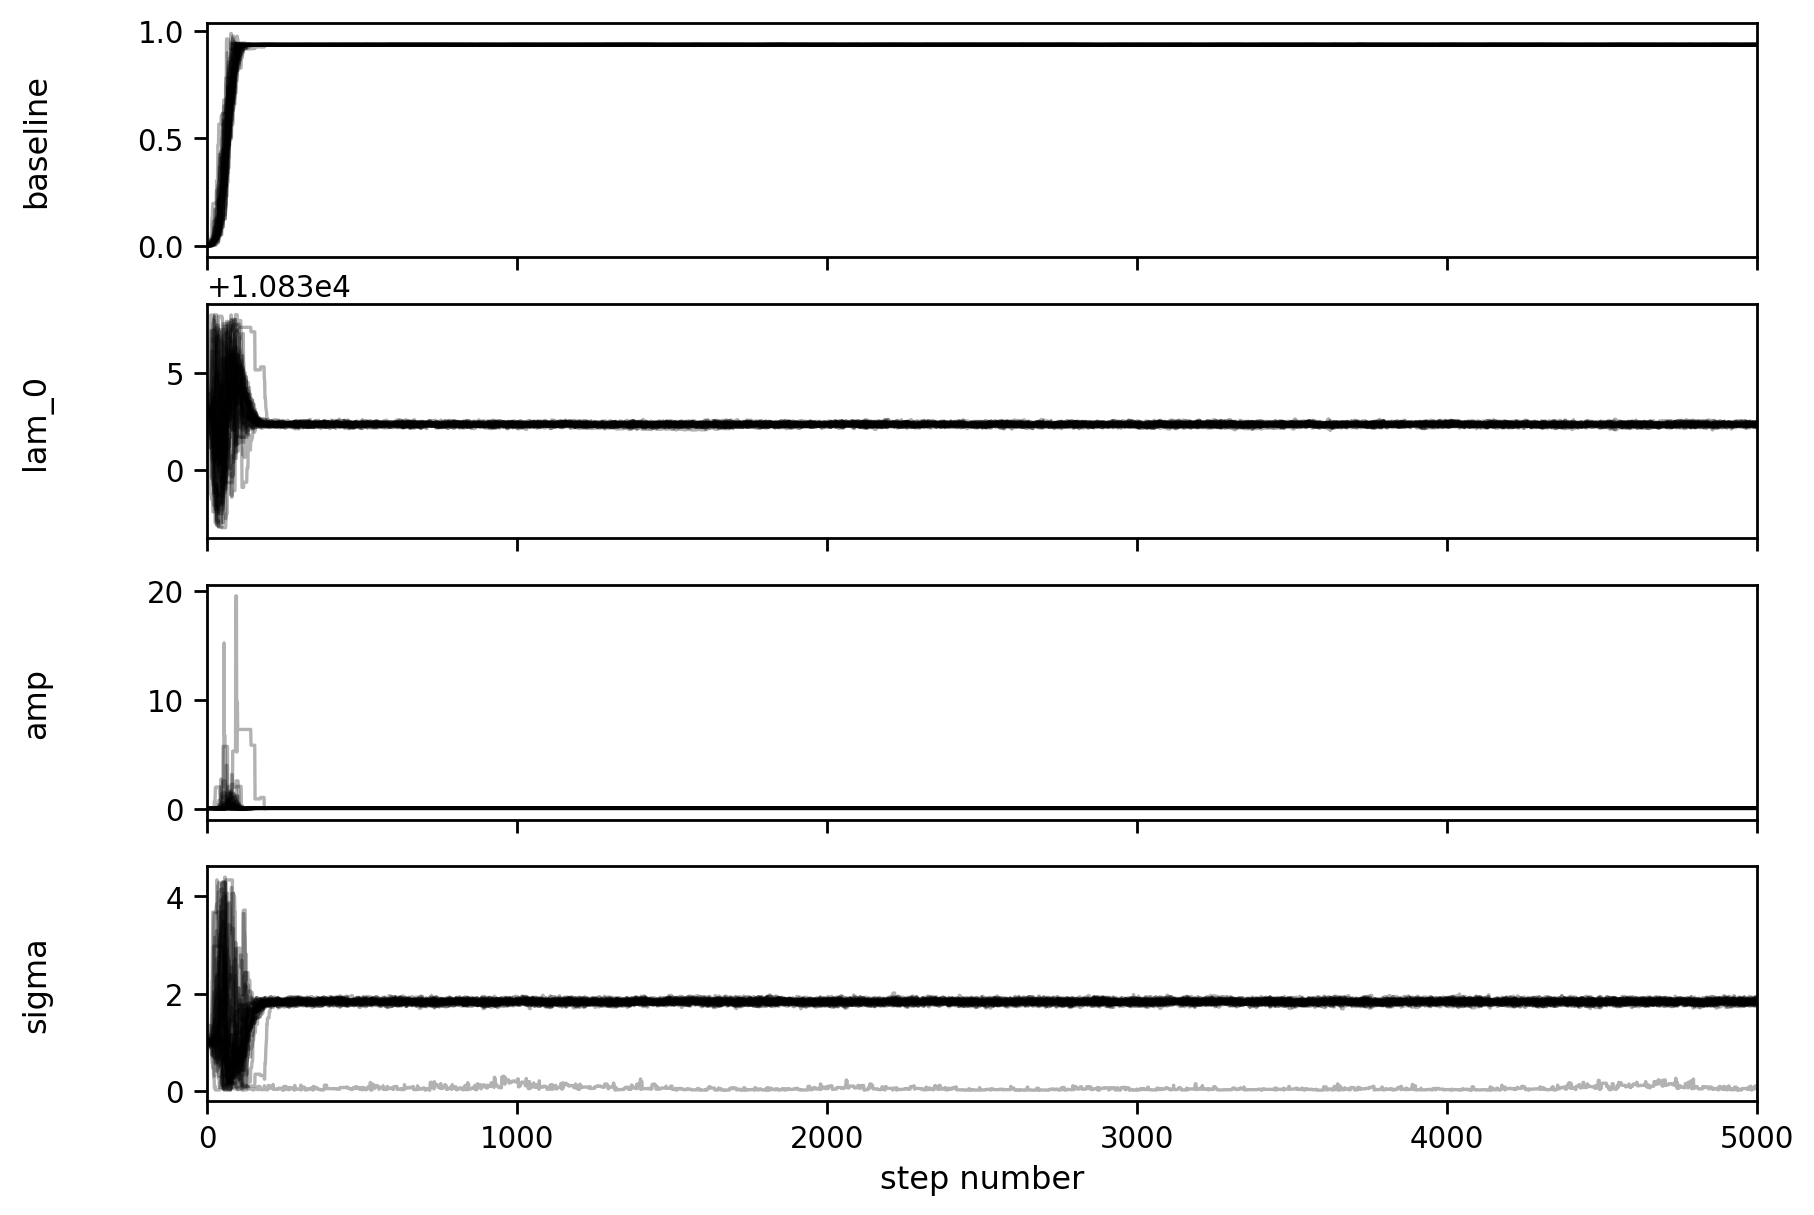

In [85]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples_orig = sampler.get_chain(discard=0)
samples = transform_samples(samples_orig)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(10824.0, 10841.0)

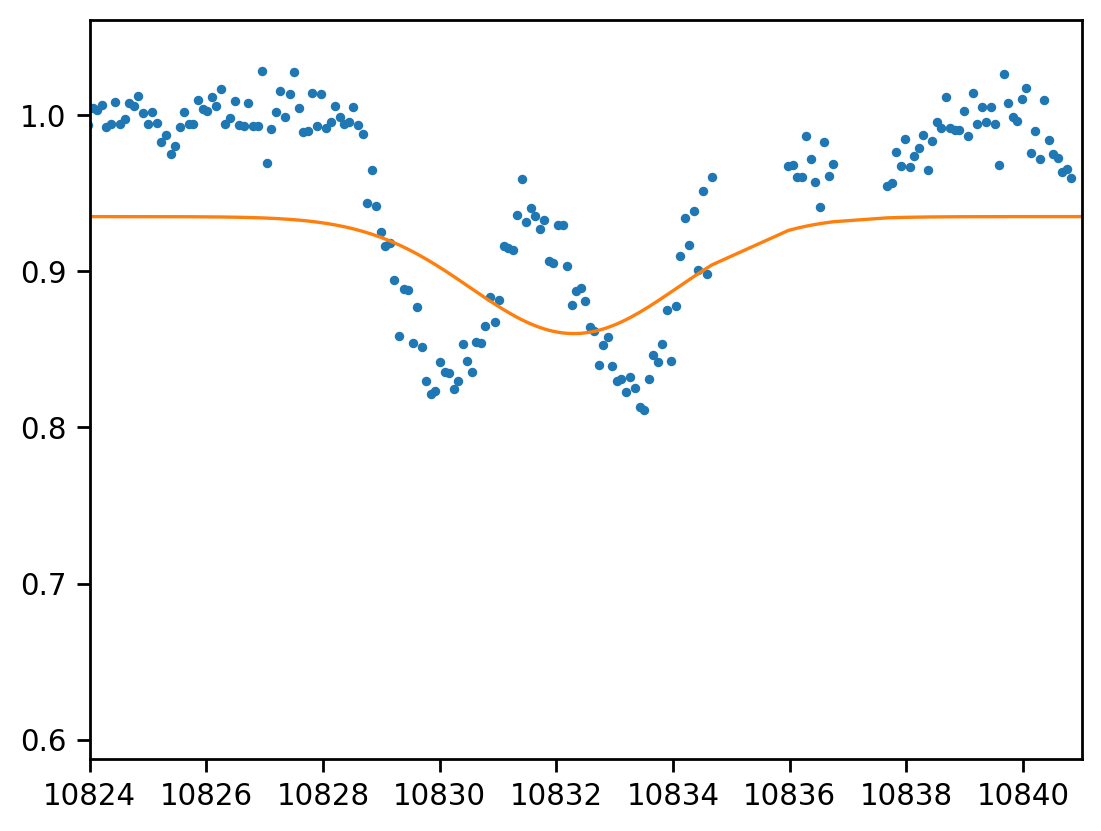

In [86]:
flux = line_model(samples_orig[-1, 13, :],\
                   wavelength=spec.wavelength.value) 

plt.plot(spec.wavelength.value, spec.flux.value, '.')
plt.plot(spec.wavelength.value, flux)
plt.xlim(10824, 10841)

In [87]:
def transform_flat_samples(samples):
    '''Convert samples to back to physical units'''    
    samples_absolute = np.copy(samples)
    # parameters 0, 1, 5 stay the same.
    
    samples_absolute[:, 2:] = np.exp(samples[:, 2:])
    return samples_absolute

In [88]:
from tqdm.notebook import tqdm_notebook

In [89]:
labels_out = sorted([label+'_lo' for label in labels] + labels + [label+'_hi' for label in labels])

df_out = pd.DataFrame()
df_out

""


In [90]:
for j, spec in tqdm_notebook(enumerate(spec_list_residue),display=True, total=len(spec_list_residue)):
    
    x = spec.wavelength.value
    y = spec.flux.value
    unc = spec.uncertainty.array
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, unc))
    sampler.run_mcmc(p0, 5000, progress=False);

    
    flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
    flat_abs_samples = transform_flat_samples(flat_samples)
    
    dict_out = {}
    for i in range(ndim):
        mcmc = np.percentile(flat_abs_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        dict_out[labels[i]] = mcmc[1]
        dict_out[labels[i]+'_lo']= q[0]
        dict_out[labels[i]+'_hi']= q[1]
    df_out = pd.concat([df_out, pd.DataFrame(dict_out, index=[j])])
    df_out.to_csv('../../data/HPF/He10830_MCMC_fits_one_Gaussian.csv', index=False)

  0%|          | 0/152 [00:00<?, ?it/s]

emcee: Exception while calling your likelihood function:
  params: [ 9.35698342e-01  1.08321329e+04 -2.61083911e+00  6.21843770e-01]
  args: (array([10821.2098214 , 10821.28890294, 10821.36797456, ...,
       10958.59803912, 10958.6544792 , 10958.71090707]), array([1.00409872, 0.99673266, 1.00439139, ..., 0.900131  , 0.92101587,
       0.89024022]), array([0.01253226, 0.0124928 , 0.01248574, ..., 0.01098088, 0.01118862,
       0.01106799]))
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/mag3842/mambaforge/envs/disperse_env/lib/python3.8/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/gb/yvbtr8b57pd1nzzxk3t_zwfsxgvdgb/T/ipykernel_70355/1135080792.py", line 3, in lnprob
    likelihood = lnlike(theta, x, y, yerr)
  File "/var/folders/gb/yvbtr8b57pd1nzzxk3t_zwfsxgvdgb/T/ipykernel_70355/892509697.py", line 2, in lnlike
    model = line_model(theta, wavelength=x)
  File "/var/folders/gb/yvbtr8b57pd1nzzxk3t_zwfsxgvdgb/T/ipykernel_70355/3655529622.py", line 6, in line_model
    return baseline - amp * np.exp(-0.5*wl_vector**2/sigma**2)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
df_out

Look at a draw from the sampler:

In [ ]:
jax_wrapper(sampler.chain[10, -100, :])

In [ ]:
param_draw = jax_wrapper(sampler.chain[10, -100, :])

gp = build_gp(param_draw)
_, cond = gp.condition(y, X, include_mean=False, diag=unc**2)

mu = cond.loc + soln.params["amps"][0]
std = np.sqrt(cond.variance)

plt.plot(X, y, ".k", label="data")
plt.plot(X_grid, mu, label="GP model")
plt.fill_between(X_grid, mu + std, mu - std, color="C0", alpha=0.3)
plt.plot(X_grid, jax.vmap(gp.mean_function)(X_grid), label="mean model")

plt.xlim(X_grid.min(), X_grid.max())
plt.xlabel("x")
plt.ylabel("y")
_ = plt.legend()

In [ ]:
plt.plot(df_out.amp1, df_out.amp2, '.')
plt.xlim(0, 2)
plt.ylim(0, 2)

In [ ]:
plt.plot(df_out.sigma2, df_out.gamma2, '.')
plt.xlim(0, 5)
plt.ylim(0, 5)

In [ ]:
plt.plot(df_out.lam1, df_out.lam2, '.')
plt.xlim(10829, 10834)
plt.ylim(10829, 10834)

In [ ]:
len(df_out)

In [ ]:
len(df)

In [ ]:
df['center_wl'] = df_out.lam2

In [ ]:
0.02

In [ ]:
df_out.iloc[0]

In [ ]:
df_out.lam1_hi.describe()

In [ ]:
df_out.lam2.describe()

In [ ]:
plt.scatter(df_out.lam1, df.normalized_phase, s=df_out.amp1*50, ec='w')

In [ ]:
plt.hist(df_out.lam1, 
         bins=np.arange(10830.045-0.2, 10830.045+0.2, 0.015));
plt.hist(np.random.normal(loc=10830.045, scale=0.02, size=152), 
         bins=np.arange(10830.045-0.2, 10830.045+0.2, 0.015), alpha=0.5);
plt.axvline(10830.045, color='k', linestyle='dashed')

In [ ]:
plt.hist(df_out.lam2, 
         bins=np.arange(10833.30-0.2, 10833.30+0.2, 0.015));
plt.hist(np.random.normal(loc=10833.30, scale=0.02, size=152), 
         bins=np.arange(10833.30-0.2, 10833.30+0.2, 0.015), alpha=0.5);
plt.axvline(10833.30, color='k', linestyle='dashed')

In [ ]:
plt.figure(figsize=(5, 15))
plt.errorbar(df_out.lam1, df.normalized_phase, xerr=(df_out.lam1_lo, df_out.lam1_hi),
             linestyle='none', color='k', alpha=0.1)
plt.scatter(df_out.lam1, df.normalized_phase, s=df_out.amp1*50, ec='w')


#plt.ylim(-0.2, 0.1)
plt.axvline(10833.4, color='k')
plt.xlim(10829.8, 10830.2)
plt.ylim(-0.05, 0.05)
plt.axvline(10830.045, color='k', linestyle='dashed')

In [ ]:
plt.figure(figsize=(8, 8))
plt.errorbar(df_out.lam2, df.normalized_phase, xerr=(df_out.lam2_lo, df_out.lam2_hi),
             linestyle='none', color='k', alpha=0.1)
plt.scatter(df_out.lam2, df.normalized_phase, s=df_out.amp2*50, ec='w')


#plt.ylim(-0.2, 0.1)
plt.axvline(10833.4, color='k')
plt.xlim(10833.4-0.7, 10833.4+0.7)
plt.ylim(-0.05, 0.05)

In [ ]:
rate = (150.0 * u.km/u.s)

In [ ]:
distance = rate * 1.0*u.day

In [ ]:
a_AU = 0.065*u.AU

In [ ]:
extent = 0.2*2*np.pi*a_AU

In [ ]:
(distance/extent).to(u.dimensionless_unscaled)

In [ ]:
plt.figure(figsize=(5, 15))
plt.errorbar(df_out.lam2, df.normalized_phase, xerr=(df_out.lam2_lo, df_out.lam2_hi),
             linestyle='none', color='k', alpha=0.1)
plt.scatter(df_out.lam2, df.normalized_phase, s=df_out.amp2*50, ec='w')


#plt.ylim(-0.2, 0.1)
plt.axvline(10833.4, color='k')
plt.xlim(10833.4-0.7, 10833.4+0.7)

In [ ]:
import astropy.constants as const

In [ ]:
velocities = (df_out.lam2-10833.4).values/10833.4 * const.c.to(u.km/u.s)

In [ ]:
plt.figure(figsize=(5, 15))
plt.scatter(velocities, df.normalized_phase, s=df_out.amp2*50, ec='w')


#plt.ylim(-0.2, 0.1)
plt.axvline(0, color='k')
plt.xlim(-20, 20)

In [ ]:
plt.figure(figsize=(5, 15))
plt.scatter(df.center_wl, df.normalized_phase, s=df_out.amp2*50, ec='w')
plt.scatter(df_out.lam1, df.normalized_phase, s=df_out.amp1*50, ec='w')

#plt.ylim(-0.2, 0.1)
plt.axvline(10833.4, color='k')
plt.xlim(10829, 10834)

Re-initialize to the a draw from the first trial to shed some hysteresis of the first coarse initialization.

In [ ]:
samples = sampler.get_chain()

p0 = samples[-1, 13, :] + perturbations.T

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_prob)
output = sampler.run_mcmc(p0, 5000, progress=True)

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
samples_absolute = transform_samples(samples)

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 14), sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_absolute[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_absolute))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
flux_model = joint_model(samples[-1, 13, :], wavelength=spec.wavelength.value) 

plt.plot(spec.wavelength.value, spec.flux.value, '.')
plt.plot(spec.wavelength.value, flux_model)
plt.xlim(10827, 10838)

Ok, good enough for our purposes!